In [10]:
import os
import sys
import math
import time
import numpy as np
import pandas as pd
from numpy import random as npr

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotly import graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['text.usetex'] = True
import datetime

In [3]:
SEED = 2021
SYNTHETC_DATASET_SIZE = 10_000
SAMPLE_SIZES = [0.1, 0.3, 0.5, 0.9]
ALPHA_SAMPLE_RATE = 20

USERPROFILE_DATASET_PATH = "/../../data/rest_data/userprofile.csv"
USERCUISINE_DATASET_PATH = "/../../data/rest_data/usercuisine.csv"
CHEFMOZCUISINE_DATASET_PATH = "/../../data/rest_data/chefmozcuisine.csv"
RATINGS_DATASET_PATH = "/../../data/rest_data/ratings_reformatted.csv"

## Load and transform restaurants data

Helper functions 

In [3]:
def prepare_user_profile_df(df):
    df = df.drop(["latitude", "longitude"], axis=1)
    df = df.replace("?", pd.NA)
    df = df.fillna(method="bfill")
    return df


def prepare_user_cuisine_df(df):
    df.drop_duplicates()
    df = df.join(pd.get_dummies(df["Rcuisine"]))
    df = df.drop("Rcuisine", axis=1)
    df = df.groupby("userID").sum()
    return df


def load_and_clean_users_df():
    user_profile_df = pd.read_csv(USERPROFILE_DATASET_PATH)
    user_cuisine_df = pd.read_csv(USERCUISINE_DATASET_PATH)
    user_profile_df = prepare_user_profile_df(user_profile_df)
    user_cuisine_df = prepare_user_cuisine_df(user_cuisine_df)

    users_df = pd.merge(user_profile_df, user_cuisine_df, on="userID")
    return users_df


def load_and_prepare_rest_cuisine_df():
    df = pd.read_csv(CHEFMOZCUISINE_DATASET_PATH)
    df = df.drop_duplicates()
    df = df.join(pd.get_dummies(df["Rcuisine"]))
    df = df.drop("Rcuisine", axis=1)
    df = df.groupby("placeID").sum()
    return df



In [ ]:
users_df = load_and_clean_users_df()
rests_df = load_and_prepare_rest_cuisine_df()

In [6]:
ratings_df = pd.read_csv(RATINGS_DATASET_PATH)
ratings_df

userID  placeID  rating  food_rating  service_rating
0     U1077   135085       2            2               2
1     U1077   135038       2            2               1
2     U1077   132825       2            2               2
3     U1077   135060       1            2               2
4     U1068   135104       1            1               2
...     ...      ...     ...          ...             ...
1156  U1043   132630       1            1               1
1157  U1011   132715       1            1               0
1158  U1068   132733       1            1               0
1159  U1068   132594       1            1               1
1160  U1068   132660       0            0               0

[1161 rows x 5 columns]

In [7]:
merged_df = pd.merge(ratings_df, users_df, on="userID")
merged_df = pd.merge(merged_df, rests_df, on="placeID")
merged_df

userID  placeID  rating  food_rating  service_rating smoker  \
0    U1077   135085       2            2               2  false   
1    U1108   135085       1            2               1  false   
2    U1081   135085       1            2               1  false   
3    U1001   135085       0            1               1  false   
4    U1056   135085       2            2               2  false   
..     ...      ...     ...          ...             ...    ...   
868  U1006   132922       2            1               2   true   
869  U1003   132937       2            2               1  false   
870  U1027   132937       1            1               1   true   
871  U1029   132937       1            1               1   true   
872  U1086   132937       2            0               1  false   

        drink_level dress_preference  ambience  transport  ... Soup_y  \
0    social drinker          elegant    family     public  ...      0   
1        abstemious         informal  solitary     public  ...      0   
2    casual drinker         informal    family     public  ...      0   
3        abstemious         informal    family    on foot  ...      0   
4    social drinker         informal    family    on foot  ...      0   
..              ...              ...       ...        ...  ...    ...   
868  social drinker    no preference   friends  car owner  ...      0   
869  social drinker           formal    family     public  ...      0   
870  social drinker    no preference    family     public  ...      0   
871  casual drinker           formal    family     public  ...      0   
872  social drinker    no preference    family  car owner  ...      0   

    Southern_y  Southwestern_y Spanish_y Steaks_y Sushi_y Thai_y Turkish_y  \
0            0               0         0        0       0      0         0   
1            0               0         0        0       0      0         0   
2            0               0         0        0       0      0         0   
3            0               0         0        0       0      0         0   
4            0               0         0        0       0      0         0   
..         ...             ...       ...      ...     ...    ...       ...   
868          0               0         0        0       0      0         0   
869          0               0         0        0       0      0         0   
870          0               0         0        0       0      0         0   
871          0               0         0        0       0      0         0   
872          0               0         0        0       0      0         0   

     Vegetarian_y Vietnamese_y  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
..            ...          ...  
868             0            0  
869             0            0  
870             0            0  
871             0            0  
872             0            0  

[873 rows x 183 columns]

In [8]:
merged_df.rating.value_counts()

2    369
1    320
0    184
Name: rating, dtype: int64

In [9]:
rests_df['placeID'] = rests_df.index
rests_df = rests_df.reset_index(drop=True)

In [10]:
users_df["userID"] = users_df["userID"].astype("category").cat.codes

Merge ratings dataset, users dataset, and restaurants dataset into single tablem

In [11]:
merged_df["userID"] = merged_df["userID"].astype("category").cat.codes
merged_df

userID  placeID  rating  food_rating  service_rating smoker  \
0        76   135085       2            2               2  false   
1       107   135085       1            2               1  false   
2        80   135085       1            2               1  false   
3         0   135085       0            1               1  false   
4        55   135085       2            2               2  false   
..      ...      ...     ...          ...             ...    ...   
868       5   132922       2            1               2   true   
869       2   132937       2            2               1  false   
870      26   132937       1            1               1   true   
871      28   132937       1            1               1   true   
872      85   132937       2            0               1  false   

        drink_level dress_preference  ambience  transport  ... Soup_y  \
0    social drinker          elegant    family     public  ...      0   
1        abstemious         informal  solitary     public  ...      0   
2    casual drinker         informal    family     public  ...      0   
3        abstemious         informal    family    on foot  ...      0   
4    social drinker         informal    family    on foot  ...      0   
..              ...              ...       ...        ...  ...    ...   
868  social drinker    no preference   friends  car owner  ...      0   
869  social drinker           formal    family     public  ...      0   
870  social drinker    no preference    family     public  ...      0   
871  casual drinker           formal    family     public  ...      0   
872  social drinker    no preference    family  car owner  ...      0   

    Southern_y  Southwestern_y Spanish_y Steaks_y Sushi_y Thai_y Turkish_y  \
0            0               0         0        0       0      0         0   
1            0               0         0        0       0      0         0   
2            0               0         0        0       0      0         0   
3            0               0         0        0       0      0         0   
4            0               0         0        0       0      0         0   
..         ...             ...       ...      ...     ...    ...       ...   
868          0               0         0        0       0      0         0   
869          0               0         0        0       0      0         0   
870          0               0         0        0       0      0         0   
871          0               0         0        0       0      0         0   
872          0               0         0        0       0      0         0   

     Vegetarian_y Vietnamese_y  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
..            ...          ...  
868             0            0  
869             0            0  
870             0            0  
871             0            0  
872             0            0  

[873 rows x 183 columns]

In [12]:
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN
import time

def _clean_dataset(df):
    df = df.drop(["userID", "placeID"], axis=1) # Drop ids
    df = df.astype("int64", errors="ignore") # Convert all numbers to int64
    return df


def fit_and_evaluate_models(df, models, sample_size, eval_kwargs):
    result = pd.DataFrame()
    for name, model in models.items():
        start = time.time()
        model.fit(df)
        model.save('./rests_models/' + str(name) + '_' + '.pkl')
        end = time.time()
        print("Fitting of " + name)
        print(end - start)
        eval_result = evaluate(df, model.sample(sample_size), **eval_kwargs)
        eval_result["model_name"] = name
        result = pd.concat([result, eval_result])
    
    return result

In [13]:
_clean_dataset(merged_df).dtypes

rating             int64
food_rating        int64
service_rating     int64
smoker            object
drink_level       object
                   ...  
Sushi_y            int64
Thai_y             int64
Turkish_y          int64
Vegetarian_y       int64
Vietnamese_y       int64
Length: 181, dtype: object

In [14]:
df=_clean_dataset(merged_df)

In [15]:
df.isna().sum().sum()

0

In [24]:
import torch

In [30]:
from sdv.evaluation import evaluate

with torch.cuda.device(0):
    _comp_result = fit_and_evaluate_models(
        df=_clean_dataset(merged_df),
        models={"GaussianCopula": GaussianCopula(), 
                "CTGAN": CTGAN(), 
                "CopulaGAN": CopulaGAN()},
        sample_size=750,
        eval_kwargs={"aggregate": False}
    )

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/copulas/univariate/truncated_gaussian.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/copulas/univariate/truncated_gaussian.py:44: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)

Fitting of GaussianCopula
77.68116497993469


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/base.py:97: RuntimeWarning: overflow encountered in exp
  score = 1 / (1 + np.exp(-raw_score))
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value solitary in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value married in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value widow in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value kids in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/da

Fitting of CTGAN
47.19263291358948


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

Fitting of CopulaGAN
110.92651557922363


ValueError: Cannot convert non-finite values (NA or inf) to integer

In [32]:
_comp_result.head()

NameError: name '_comp_result' is not defined

In [14]:
rs = _comp_result[
    (_comp_result.metric != "BNLogLikelihood") &
    (_comp_result.metric != "GMLogLikelihood") &
    (_comp_result.metric != "KSTestExtended") &
    (_comp_result.metric != "ContinuousKLDivergence") &
    (_comp_result.metric != "DiscreteKLDivergence") &
    (_comp_result.metric != "CSTest")
]

NameError: name '_comp_result' is not defined

In [ ]:
rs_time_data = {'metric': ['FitTime', 'FitTime', 'FitTime'],
               'name': ['Fitting time', 'Fitting time', 'Fitting time'],
               'score': [1-0.005, 1-0.49, 1-0.5],
               'min_value': [0, 0, 0],
               'max_value': [1, 1, 1],
               'goal': ['MINIMIZE', 'MINIMIZE', 'MINIMIZE'],
               'model_name': ['GaussianCopula', 'CTGAN', 'CopulaGAN']}
rs_time = pd.DataFrame(rs_time_data)

In [316]:
rs = rs.append(rs_time)

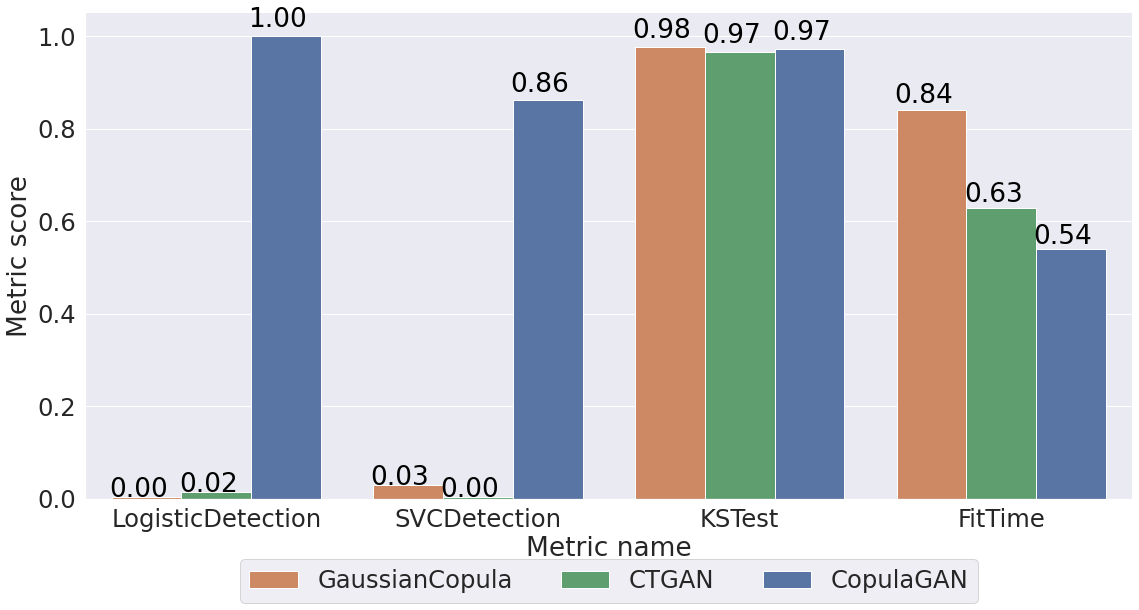

In [333]:
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
rs["Model name"] = rs["model_name"]
rs["Metric score"] = rs["score"]
rs["Metric name"] = rs["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs.iloc[0, 2], rs.iloc[1, 2], rs.iloc[2, 2], rs.iloc[9, 2], 
               rs.iloc[3, 2], rs.iloc[4, 2], rs.iloc[5, 2], rs.iloc[10, 2], 
               rs.iloc[6, 2], rs.iloc[7, 2], rs.iloc[8, 2], rs.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)